# Organize code for model comparison and validation!

I wanted to show you how I organize my code to compare and validate different machine
learning models

I'll explain this using the example of Linear Regression. The dataset that we're going
to be using is called the __mpg__ dataset.

It's generally a good practice to have all your imports at the top of your notebook.
This helps people who're looking at your notebook to easily understand all the packages
you'll be needing to run the notebook.

In [1]:
import typing
from functools import partial
from pprint import pprint

import numpy as np
import plotnine as pn
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing_extensions import Protocol
from sklearn.linear_model.base import LinearModel
from plotnine.data import mpg
%matplotlib inline

c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


We will be using a toy dataset – automobile_mpg to follow along. The mpg dataset contains info collected by the US Environmental Protection Agency on 38 brands of cars. 

We use this dataset to predict # miles per gallon an automobile can run for, which is a continuous problem. Hence this is a regression problem.


The features used for prediction are # cylinders the car has, displacement the size of the car engine in litres, horsepower, weight, acceleration of the car and age of the car.

In [2]:
automobile_df = pd.read_csv('data/auto_mpg_processed.csv')
print(automobile_df.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  Age
0  30.0          4         111.0        80.0    2155          14.8   42
1  14.0          8         318.0       150.0    4077          14.0   47
2  30.0          4         146.0        67.0    3250          21.8   39
3  13.0          8         400.0       175.0    5140          12.0   48
4  17.5          8         318.0       140.0    4080          13.7   41


Let's see if we can identify the different factors that affect the mileage of a car.

Do you think cars with bigger engines use more fuel than cars with smaller engines?

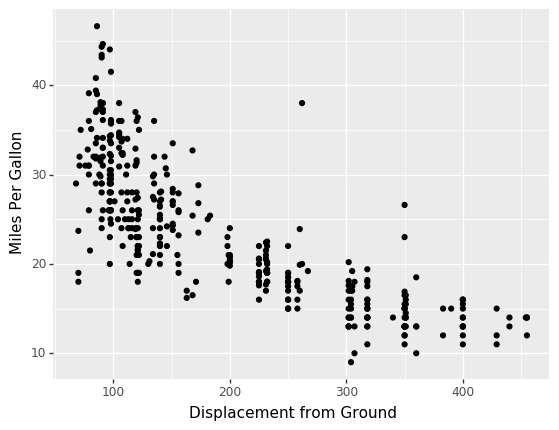

<ggplot: (-9223371915454427984)>

In [3]:
(
    pn.ggplot(automobile_df) +
    pn.geom_point(pn.aes(x = 'displacement', y= 'mpg')) + 
    pn.xlab('Displacement from Ground') + 
    pn.ylab('Miles Per Gallon')
)

Let's try to fit our own line to the dataset.

What is happening to the mileage as the engine size is increasing?

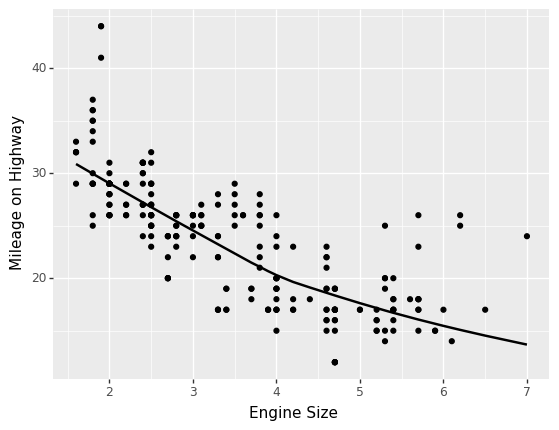

<ggplot: (-9223371915433315060)>

In [4]:
(
    pn.ggplot(data=mpg, mapping=pn.aes(x="displ", y="hwy")) +
    pn.geom_point() + 
    pn.stat_smooth(se=False, method= 'lowess') +
    pn.xlab("Engine Size") + 
    pn.ylab("Mileage on Highway")
)

Now a Data Scientist generally spends a majority of their time on "tidying" up the data.
This involves dealing with missing data, corrupted data, munging data from different
sources into a single table and so on. Since I'm not focusing on that in today's talk,
I'm going to use this dataset that I've already preprocessed for the rest of the talk.

What is the structure of our code going to look like?

Typing module provides run time support for type hints. A type alias is defined by assigning a type to the alias. For example ModelData is a Named Tuple. It has inputs and has targets. As you can see, Type aliases are useful for simplifying complex type signatures.

Type hints are useful as they act as self-documentation and make it easier to read code. It helps in catching bugs without actually running the code. We can use it to create code structures.

They are templates, blueprints for creating classes and functions. 

In [5]:
class ModelData(typing.NamedTuple):
    inputs: np.ndarray
    targets: np.ndarray
    

class DataSplits(typing.NamedTuple):
    train: ModelData
    test: ModelData
    
    
# Generate training and testing data
class TrainValSplitFn(Protocol):
    """ This is the API that the function calls for generating the training and validation
    splits
    
    """
    def __call__(self, data: ModelData) -> DataSplits:
        raise NotImplementedError

# Any data transformation
class TransformDataFn(Protocol):
    """ Any data transformation we do will be using a function with this API. 
    
    Such a data transformation function would just take in the input data (X) and return
    a transformed copy of the data. 
    
    NOTE: Do NOT modify the input data. Create a copy and modify it instead. In general,
    it's better to keep our functions devoid of any side effects. Modifying the inputs
    of a function, modifying the file system etc are examples of side effects. Functions
    which do not have any side effects are called "pure" functions.
    """
    def __call__(self, data: ModelData) -> ModelData:
        raise NotImplementedError

# Fit model
class FitModelFn(Protocol):
    """ All our models will follow this API.
    
    Our models are going to be functions that take in the train and test data frames,
    and return a learned LinearModel.
    """
    def __call__(self, data: ModelData) -> LinearModel:
        raise NotImplementedError


# Generate validation metrics
class ValidationMetrics(typing.NamedTuple):
    """ The set of metrics that we're interested in when comparing different models. """
    test_score: float
    training_score: float
    

class ValidationMetricsFn(Protocol):
    """ Function that generates the metrics for validating the model performance. """
    def __call__(self, model: LinearModel, data: DataSplits) -> ValidationMetrics:
        raise NotImplementedError
    
    
class PlotFn(Protocol):
    """ Function that does any required plotting for us. """
    def __call__(self, model: LinearModel, data: DataSplits) -> typing.Any:
        raise NotImplementedError
    
    

Let's generate the train test splits for our data

In [6]:
def ensure_2d(data: ModelData) -> ModelData:
    """ If the data has less than 2 dims, expand it to at least 2D. """
    return ModelData(
        inputs=data.inputs.reshape(-1, 1), targets=data.inputs.reshape(-1, 1)
    )


def standard_scaling_data_transform(data: ModelData) -> ModelData:
    """ 
    Standardize features by removing mean and scaling to unit variance.
    
    Implements the StandardScaler object from sklearn preprocessing.
    
    Standardization of dataset is a common requirement for many machine
    learning algorithms as they assume all features are centered around
    0 and have variance in same order. If a feature has variance that is 
    orders of magnitude larger than others, it might dominate the 
    objective function and make the estimator unable to learn from 
    other features correctly as expected.
    """
    pre_processor = StandardScaler()
    return ModelData(
        inputs=pre_processor.fit_transform(data.inputs),
        targets=data.targets
    )


def dummy_data_transform(data: ModelData) -> ModelData:
    """ Returns data as is. Useful for passing in as a default data transform when you
    don't want to do any data transformation. This design patterns is called null 
    object pattern. - doesn't do anything. It avoids if else type statements.
    
    """
    return data


def dummy_plot(model: LinearModel, data: ModelData) -> None:
    pass
    
    
def simple_validation(model: LinearModel, data: DataSplits) -> ValidationMetrics:
    '''
    Function calculates the r-square scores for the test and training dataset.
    
    R-square metric is the proportion of variation of sum of squared deviations 
    from the mean that is explained by the model. In other words, how good is our 
    regression model compared to a very simple model that just predicts the mean 
    value of response from the train set as predictions? How much of variation of 
    the response is explained by the regression? If it is 0, your model isn’t 
    explaining anything, if it is closer to 1 your model is getting better at 
    predicting the response.
    
    R-square doesn’t consider the number of variables in the model. So it doesn’t 
    penalize complex models, rather complex models tend to have non-decreasing 
    r-squares. That is as you add more variables r-square only increases. Hence this
    metric should be used with caution.
    
    Function implements the r2_score from sklearn metrics

    '''
    predictions = model.predict(data.test.inputs)
    training_score = model.score(data.train.inputs, data.train.targets)
    test_score = r2_score(data.test.targets, predictions)
    return ValidationMetrics(test_score=test_score, training_score=training_score)


def create_data_splits(
    data_frame: pd.DataFrame,
    input_columns: typing.List[str],
    target_column: str,
    test_size: float = 0.2,
    data_transform: TransformDataFn = dummy_data_transform,
) -> DataSplits:
    '''
    Function splits data into train and test data splits. 
    
    Default size of test data is 20%. This can be changed through the
    test_size float parameter.
    
    Implements train_test_split from sklearn model_selection.
    '''
    model_data = ModelData(
        inputs=data_frame[input_columns].values,
        targets=data_frame[target_column].values,
    )
    transformed_data = data_transform(model_data)
    x_train, x_test, y_train, y_test = train_test_split(
        transformed_data.inputs, transformed_data.targets, test_size=test_size
    )
    return DataSplits(
        train=ModelData(x_train, y_train), test=ModelData(x_test, y_test)
    )

Now that we've defined the structure of helper functions, let's use them to write the
function that is going to go through the transformation, training and validation loop
and report the results for us. We can then use this function for every new model that
we want to test.

In [36]:
def try_model(
    model_trainer: FitModelFn,
    data_frame: pd.DataFrame,
    input_columns: typing.List[str],
    target_column: str,
    validation_fn: ValidationMetricsFn,
    plot_fn: PlotFn = dummy_plot,
    test_size: float = 0.2,
    data_transform: TransformDataFn = dummy_data_transform,
):
    """ 
    Intro: This function allows you to try different linear models on your dataset.
    
    Usage Examples: 
    
    Try liear regression model on your data by specifying input and response variables.
    
    >>> try_model(
    ...     model_trainer=linear_reg,
    ...     data_frame=automobile_df,
    ...     input_columns='weight displacement horsepower acceleration'.split(),
    ...     target_column='mpg',
    ...     validation_fn=simple_validation,
    ...     plot_fn=plot_predictions_vs_targets,
    ...     test_size=0.3,
    ... )
    
    Try linear model changing hyper parameters using partial.
    
    >>> alphas = [0.25,0.5,0.75, 1]
    >>> elastic_net_regression_metrics_ls = []
    >>> for alpha in alphas:
    ...     metrics = try_model(
    ...         model_trainer=partial(elastic_net_reg, alpha=alpha, l1_ratio=0.5),
    ...         data_frame=automobile_df,
    ...         input_columns='weight displacement horsepower acceleration'.split(),
    ...         target_column="mpg",
    ...         validation_fn=simple_validation,
    ...         plot_fn=plot_predictions_vs_targets,
    ...     )
    ...     elastic_net_regression_metrics_ls.append(metrics)
    
    Try different linear models.
    
    >>> models = [linear_svr,knn_reg,sgd_reg,dtreg]
    >>> results = {}
    >>> i = 1
    >>> for model in models:
    ...     result = try_model(
    ...         model_trainer=model,
    ...         data_frame=automobile_df,
    ...         input_columns='weight displacement horsepower acceleration'.split(),
    ...         target_column="mpg",
    ...         validation_fn=simple_validation,
    ...         plot_fn=dummy_plot,
    ...     )
    ...     results[i] = result
    ...     i = i+1
    
    Why is this function necessary?
    
    It would be many more lines of code to achieve the same task without this function.
    To try simple linear regression, you have to standardize data set, create test and train splits,
    instantiate the linear regression object specifying the hyper parameters, call fit method on the training
    data, call predict method on training data, calculate the r-square metrics and write your plotting function
    to visualize results. To try another linear model, say elastic net, you have to execute above
    steps all over again. This would create bulky code that is harder to scale and manage. This
    function simplifies the process greatly.
    
    Linear Regression without this function is many lines of code:
    
    >>> inputs, targets = automobile_df.loc[:,'weight displacement horsepower acceleration'.split()], automobile_df['mpg']
    >>> x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.2)
    >>> model = LinearRegression()
    >>> model.fit(x_train, y_train)
    >>> y_pred = model.predict(x_test)
    >>> # Plots
    ... plt.plot(y_test, y_pred)
    >>> # Validation Scores
    ... training_score = model.score(x_train,y_train)
    
    Functionality:
    
    The inputs to the function are the linear model that should be tried on data. Linear models could be 
    Linear Regression, Lasso, Ridge, Elastic Net, Decision Tree regression, Least Angle Regression, Support
    Vector Regression, K-NN regression, Stochastic Gradeint Regression. The second input is the data. The 
    independent and response variables are specified as list of strings and strings under the input_columns
    and target_columns. Validation and plot functions can also be specified. By default 20% 
    data is reserved for test or hold-out and the remaning data is used to train model. This can be changed
    by changing the parameter test_size. Try data transformation for non-centered data using the 
    data_transform parameter. Default is dummy. 
    
    The first step is to defining model data by separating independent and response variables into inputs
    and targets. If data transformation is specified, the inputs are transformed with the chosen method.
    Data is split into training and test and chosen model is fitted on the training data. Chosen plots are 
    displayed and function returns the validation metrics.
    """
    model_data = ModelData(
        inputs=data_frame[input_columns].values,
        targets=data_frame[target_column].values,
    )
    transformed_data = data_transform(model_data)
    x_train, x_test, y_train, y_test = train_test_split(
        transformed_data.inputs, transformed_data.targets, test_size=test_size
    )
    data = DataSplits(
        train=ModelData(x_train, y_train), test=ModelData(x_test, y_test)
    )
    model = model_trainer(data.train)
    print(plot_fn(model, data))
    return validation_fn(model, data)

In [38]:
try_model?

And let's throw in some plotting functions

In [8]:
def plot_predictions_vs_targets(model: LinearModel, data: DataSplits) -> pn.ggplot:
    data_frame = pd.DataFrame.from_dict(
        dict(
            targets=data.test.targets.flat,
            predictions=model.predict(data.test.inputs).flat
        )
    )
    data_frame['obs_nbr'] = np.arange(len(data_frame))+1
    data_frame = pd.melt(data_frame,id_vars = 'obs_nbr', value_vars = ['targets','predictions']).reset_index()
    return (
        pn.ggplot(data=data_frame) +
        pn.geom_line(mapping=pn.aes(x = 'obs_nbr', y='value', color = 'variable')) + 
        pn.xlab('Observations')+
        pn.ylab('Miles per Gallon') + 
        pn.ggtitle('Predicted vs Actual')
    )

Let's compare some models now!!!

In [9]:
split_data = create_data_splits(
    data_frame=automobile_df,
    input_columns=["weight"],
    target_column="mpg",
)

In [10]:
def linear_reg(data: ModelData) -> LinearRegression:
    x_train, y_train = data
    model = LinearRegression(normalize=True)
    model.fit(x_train,y_train)
    
    return model

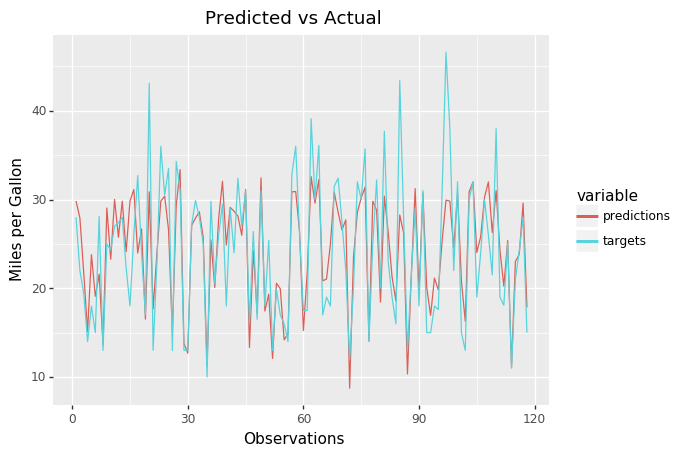

<ggplot: (-9223371915433171680)>
ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019)


In [11]:
linear_regression_metrics = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns=["weight"],
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict = {}
result_dict['Simple Linear Regression'] = linear_regression_metrics
print(linear_regression_metrics)

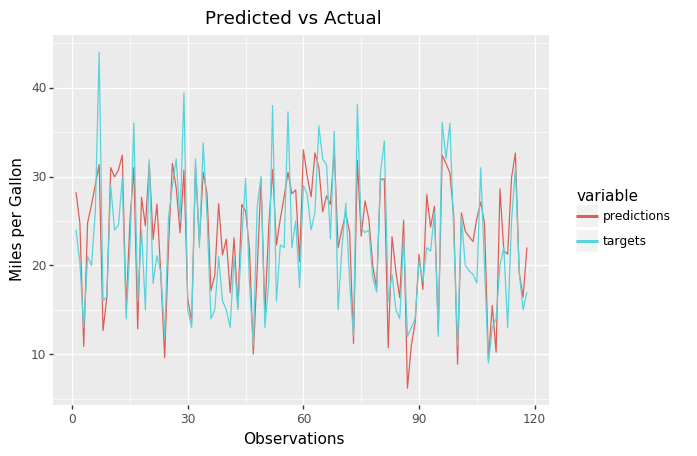

<ggplot: (-9223371915433227716)>
ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323)


In [12]:
multiple_regression_metrics_all_vars = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Multiple Regression using all available variables'] = multiple_regression_metrics_all_vars
print(multiple_regression_metrics_all_vars)

In [21]:
result_dict

{'Simple Linear Regression': ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.81630171712875, training_score=0.8044356893944651),
 'Lasso Regression': ValidationMetrics(test_score=0.7357844123051643, training_score=0.6898555618802052),
 'Ridge Regression': ValidationMetrics(test_score=0.6736088356338839, training_score=0.6719911749995606),
 'Elastic Net Regression': ValidationMetrics(test_score=0.710193646962732, training_score=0.7038054511983595),
 'Linear Support Vector Regression': ValidationMetrics(test_score=0.6911154846369529, training_score=0.7013104831973023),
 'K Nearest Neighbors Regression': ValidationMetrics(test_score=0.6842923214637457, training_score=0.7706537765704292),
 'Stochastic Gradient Regression': ValidationMetrics(test_score=-8

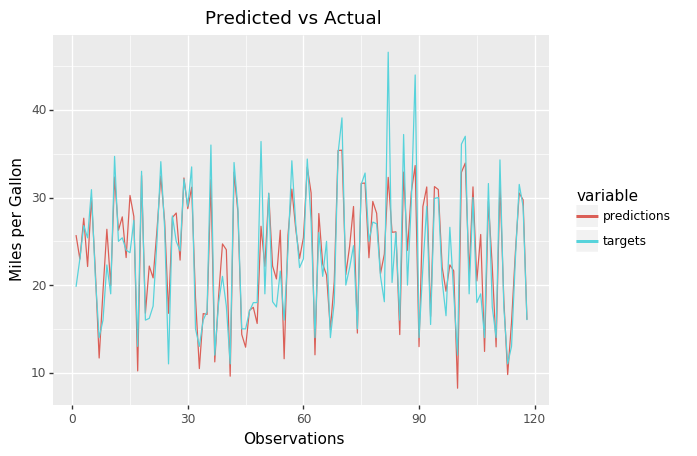

<ggplot: (-9223371915433148916)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.81630171712875, training_score=0.8044356893944651)}

In [14]:
parsimonious_regression_metrics = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns='weight Age'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Parsimonious Liear Regression'] = parsimonious_regression_metrics
result_dict

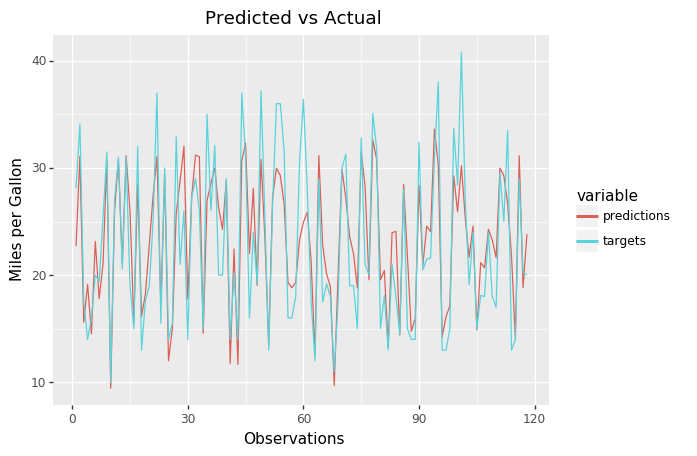

<ggplot: (-9223371915430808224)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.81630171712875, training_score=0.8044356893944651),
 'Lasso Regression': ValidationMetrics(test_score=0.7357844123051643, training_score=0.6898555618802052)}

In [15]:
def lasso_reg(
    data : ModelData,
    alpha = 0.5,
) -> Lasso:
    x_train, y_train = data
    model = Lasso(alpha = alpha)
    model.fit(x_train, y_train)
    
    return model  

lasso_regression_metrics = try_model(
    model_trainer=lasso_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Lasso Regression'] = lasso_regression_metrics
result_dict

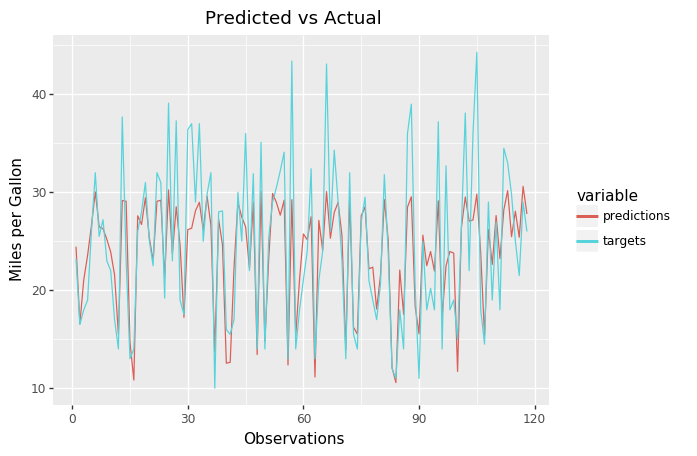

<ggplot: (-9223371915429672444)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.81630171712875, training_score=0.8044356893944651),
 'Lasso Regression': ValidationMetrics(test_score=0.7357844123051643, training_score=0.6898555618802052),
 'Ridge Regression': ValidationMetrics(test_score=0.6736088356338839, training_score=0.6719911749995606)}

In [16]:
def ridge_reg(
    data: ModelData,
    alpha=0.5,
    normalize = True,
) -> Ridge:
    x_train, y_train = data
    model = Ridge(alpha = alpha, normalize=normalize)
    model.fit(x_train, y_train)
    
    return model

ridge_regression_metrics = try_model(
    model_trainer=ridge_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)

result_dict['Ridge Regression'] = ridge_regression_metrics
result_dict

c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2754.7496603264326, tolerance: 1.86009477316294
  positive)


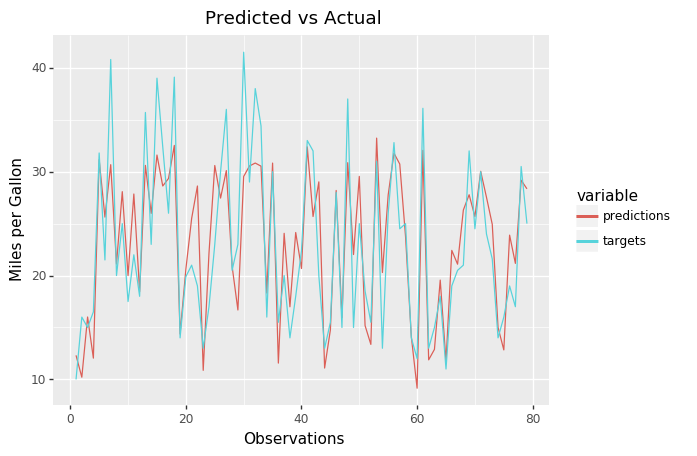

<ggplot: (-9223371915429638484)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7019340986822014, training_score=0.6857549493364019),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.679622861282575, training_score=0.7103294438320323),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.81630171712875, training_score=0.8044356893944651),
 'Lasso Regression': ValidationMetrics(test_score=0.7357844123051643, training_score=0.6898555618802052),
 'Ridge Regression': ValidationMetrics(test_score=0.6736088356338839, training_score=0.6719911749995606),
 'Elastic Net Regression': ValidationMetrics(test_score=0.710193646962732, training_score=0.7038054511983595)}

In [17]:
def elastic_net_reg(
    data: ModelData,
    alpha = 0.3,
    l1_ratio = 0.5,
    max_iter = 100000,
    warm_start = True
) -> ElasticNet:
    x_train, y_train = data
    model = ElasticNet(alpha = alpha,l1_ratio = l1_ratio, max_iter = max_iter, warm_start = warm_start)
    model.fit(x_train,y_train)
    
    return model


elastic_net_regression_metrics = try_model(
    model_trainer=partial(elastic_net_reg, alpha=0, l1_ratio=0.5),
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
)

result_dict['Elastic Net Regression'] = elastic_net_regression_metrics
result_dict

In [32]:
def linear_svr(data = ModelData, kernel = 'linear', C=0.3, epsilon=0.05) -> SVR:
    x_train, y_train = data
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(x_train, y_train)
    
    return model

def knn_reg(data = ModelData, n_neighbors = 10) -> KNeighborsRegressor:
    x_train, y_train = data
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(x_train, y_train)
    
    return model

def sgd_reg(data = ModelData, max_iter = 10000, tol = 1e-3, l1_ratio = 0.907, alpha = 0.4755) -> SGDRegressor:
    x_train, y_train = data
    model = SGDRegressor(max_iter=max_iter, tol=tol, l1_ratio=l1_ratio, alpha=alpha)
    model.fit(x_train, y_train)
    
    return model

def dtreg(data = ModelData, max_depth=2) -> DecisionTreeRegressor:
    x_train, y_train = data
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x_train, y_train)
    
    return model

In [33]:
# Try many linear models
models = [linear_svr,knn_reg,sgd_reg,dtreg]
results = {}
i = 1
for model in models:
    result = try_model(
        model_trainer=model,
        data_frame=automobile_df,
        input_columns='weight displacement horsepower acceleration'.split(),
        target_column="mpg",
        validation_fn=simple_validation,
        plot_fn=dummy_plot,
    )
    results[i] = result
    i = i+1

# Save model results to result_dict
result_dict['Linear Support Vector Regression'] = results[1]
result_dict['K Nearest Neighbors Regression'] = results[2]
result_dict['Stochastic Gradient Regression'] = results[3]
result_dict['Decision Tree Regression'] = results[4]

None
None
None
None


In [19]:
pd.DataFrame.from_dict(result_dict, orient='index').to_csv('tests/Model_simple_validation_scores.csv')

### Appendix

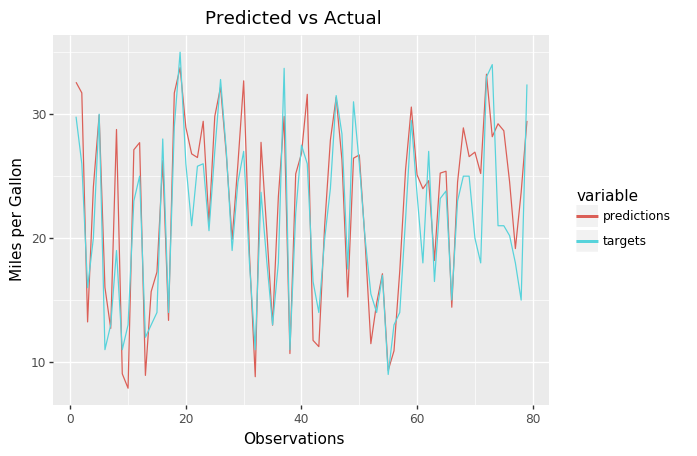

<ggplot: (-9223371915429573860)>


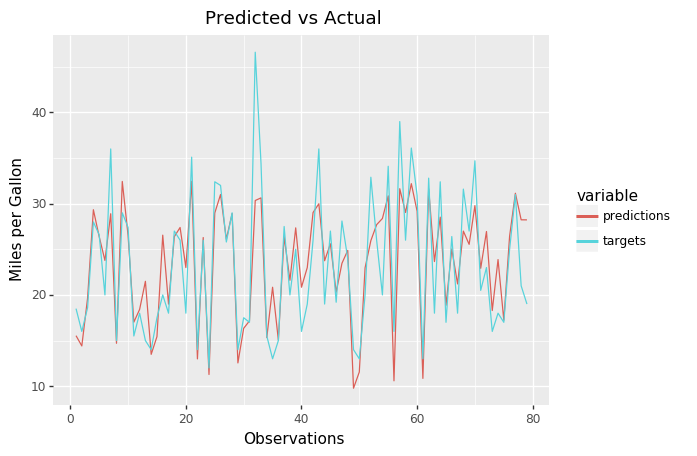

<ggplot: (-9223371915429073644)>


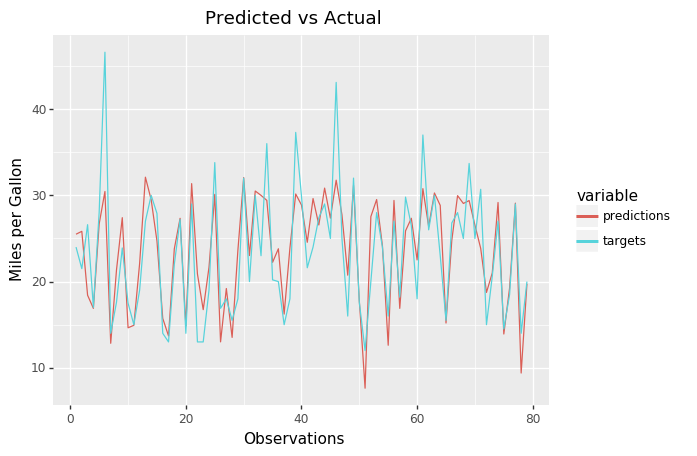

<ggplot: (-9223371915428158252)>


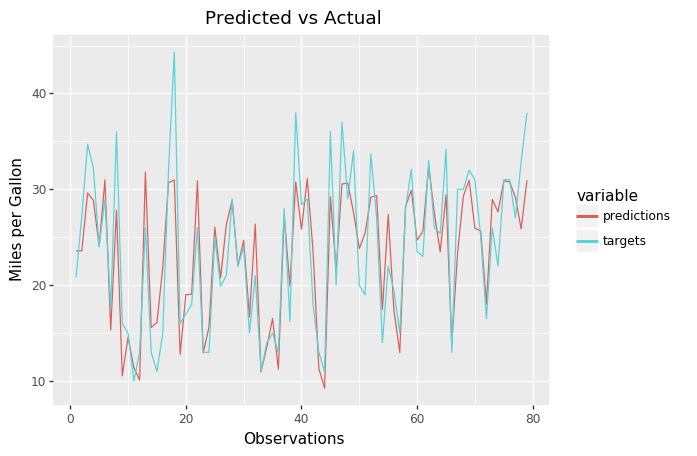

<ggplot: (-9223371915429571980)>
ValidationMetrics(test_score=0.6910891152544185, training_score=0.7007739569385645)
ValidationMetrics(test_score=0.7110343204192224, training_score=0.7058829898379423)
ValidationMetrics(test_score=0.6769950476137148, training_score=0.7130884093482185)
ValidationMetrics(test_score=0.7654083980812845, training_score=0.6898758292011073)


[None, None, None, None]

In [27]:
alphas = [0.25,0.5,0.75, 1]
elastic_net_regression_metrics_ls = []
for alpha in alphas:
    metrics = try_model(
        model_trainer=partial(elastic_net_reg, alpha=alpha, l1_ratio=0.5),
        data_frame=automobile_df,
        input_columns='weight displacement horsepower acceleration'.split(),
        target_column="mpg",
        validation_fn=simple_validation,
        plot_fn=plot_predictions_vs_targets,
    )
    elastic_net_regression_metrics_ls.append(metrics)

In [28]:
elastic_net_regression_metrics_ls

[ValidationMetrics(test_score=0.6910891152544185, training_score=0.7007739569385645),
 ValidationMetrics(test_score=0.7110343204192224, training_score=0.7058829898379423),
 ValidationMetrics(test_score=0.6769950476137148, training_score=0.7130884093482185),
 ValidationMetrics(test_score=0.7654083980812845, training_score=0.6898758292011073)]

In [30]:
models = [linear_svr,knn_reg,sgd_reg,dtreg]
results = {}
i = 1
for model in models:
    result = try_model(
        model_trainer=model,
        data_frame=automobile_df,
        input_columns='weight displacement horsepower acceleration'.split(),
        target_column="mpg",
        validation_fn=simple_validation,
        plot_fn=dummy_plot,
    )
    results[i] = result
    i = i+1

None
None
None
None


In [31]:
results[1]

ValidationMetrics(test_score=0.661931524264607, training_score=0.7113441312382034)

In [35]:
inputs, targets = automobile_df.loc[:,'weight displacement horsepower acceleration'.split()], automobile_df['mpg']
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.2)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# Plots
plt.plot(y_test, y_pred)
# Validation Scores
training_score = model.score(x_train,y_train)
test_score = r2_score(y_test, y_pred)

(     weight  displacement  horsepower  acceleration
 0      2155         111.0        80.0          14.8
 1      4077         318.0       150.0          14.0
 2      3250         146.0        67.0          21.8
 3      5140         400.0       175.0          12.0
 4      4080         318.0       140.0          13.7
 ..      ...           ...         ...           ...
 387    2228         113.0        95.0          14.0
 388    4746         400.0       170.0          12.0
 389    1985          91.0        68.0          16.0
 390    2720         140.0        88.0          15.4
 391    2740         151.0        88.0          16.0
 
 [392 rows x 4 columns], 0      30.0
 1      14.0
 2      30.0
 3      13.0
 4      17.5
        ... 
 387    25.0
 388    13.0
 389    34.1
 390    25.1
 391    24.5
 Name: mpg, Length: 392, dtype: float64)